Updated: 18/03/24

This workbook looks for the linear (2,0,n,+/-) 'memory' QNMs in the (l_min,0) spherical modes, in the nospin CCE waveforms. 

1) Check for linear modes in individual spherical modes
2) Do a mapping on the linear modes
3) Do a mapping on the quadratic m=0 modes [(2,2,0,1,2,-2,0,-1), (3,3,0,1,3,-3,0,-1)] for evidence of presence in the signal. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qnmfitsrd as qnmfits
from multiprocessing import Pool
from spatial_reconstruction import *
import matplotlib.pyplot as plt
from qnmfitsrd.CCE_file_getter import *

In [2]:
l_max = 8
n_max = 1

In [4]:
sim1 = CCE_to_sim_high_res(sim_num='0001')
sim2 = CCE_to_sim_high_res(sim_num='0010')

/tmp/ipykernel_6290/2201196235.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


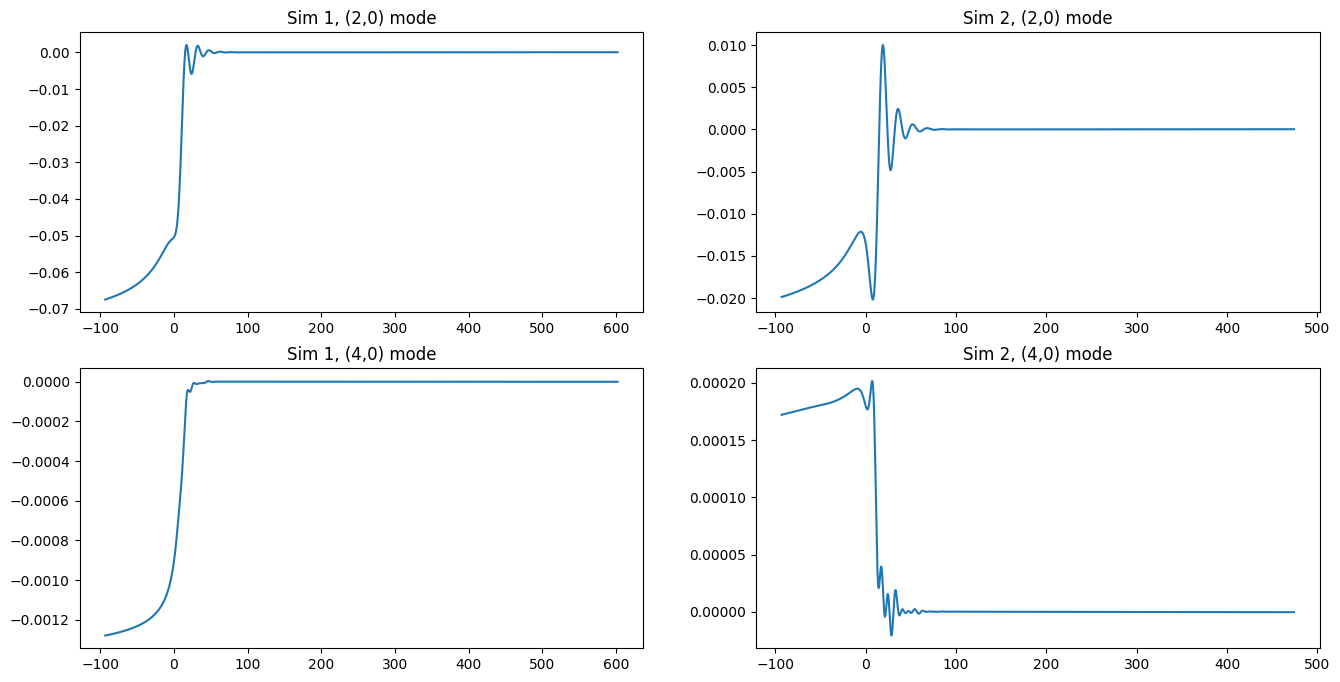

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,8)) 

ax[0,0].plot(sim1.times, sim1.h[2,0].real)
ax[0,1].plot(sim2.times, sim2.h[2,0].real)
ax[1,0].plot(sim1.times, sim1.h[4,0].real)
ax[1,1].plot(sim2.times, sim2.h[4,0].real)

ax[0,0].set_title('Sim 1, (2,0) mode')
ax[0,1].set_title('Sim 2, (2,0) mode')
ax[1,0].set_title('Sim 1, (4,0) mode')
ax[1,1].set_title('Sim 2, (4,0) mode')

fig.show() 

### Is the (2,0,0,1) mode present in the individual spherical modes?

In [ ]:
t0 = 20

model_l2 = [(2,0,n,1) for n in range(2+1)]
model_q = [(4,4,n,1) for n in range(1+1)] + [(2,2,0,1,2,2,0,1)]

best_fit_l2 = qnmfits.ringdown_fit(
    sim.times,
    sim.h[4,4],
    model_l2,
    Mf=sim.Mf,
    chif=sim.chif_mag,
    t0=t0,
)

best_fit_q = qnmfits.ringdown_fit(
    sim.times,
    sim.h[4,4],
    model_q,
    Mf=sim.Mf,
    chif=sim.chif_mag,
    t0=t0,
)

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True)

ax[0].set_title('Comparison of NR and model (real part only)')

ax[0].plot(sim.times, abs(sim.h[4,4].real), c='black', label = 'NR') 
ax[0].plot(best_fit_q['model_times'], abs(best_fit_q['model'].real), c='b', linestyle='dashed', label = 'Quadratic model')
ax[1].set_xlabel('$t_0 - t^{h_{22}}_\mathrm{peak}\ [M]$')
ax[0].set_ylabel('$|h|$')
ax[0].legend()
ax[0].set_yscale('log')
ax[0].set_xlim(-9, 80)
ax[0].set_ylim(1e-6, 1e-1)

interpolated_model_l2 = np.interp(sim.times, best_fit_l2['model_times'], best_fit_l2['model'])
interpolated_model_q = np.interp(sim.times, best_fit_q['model_times'], best_fit_q['model'])

ax[1].set_ylabel('$|h^{NR} - h^{model}|$')
ax[1].plot(sim.times, abs(sim.h[4,4] - interpolated_model_l2), c='r', label = 'Linear model')
ax[1].plot(sim.times, abs(sim.h[4,4] - interpolated_model_q), c='b', linestyle='dashed', label = 'Quadratic model')
ax[1].set_yscale('log')
ax[1].legend()

### Mapping linear modes 

In [92]:
sim = CCE_to_sim_high_res(sim_num='0010')

In [93]:
lon = np.linspace(-np.pi, np.pi, 200)
lat = np.linspace(-np.pi/2, np.pi/2, 200)
Lon, Lat = np.meshgrid(lon, lat)

t_start = -50
t_end = 200
t_step = 1
times = np.arange(t_start, t_end, t_step)

mapping = [(2,0,0,1)]
map = mapping[0]
l,m,n,p = map

QNMs = [(lam,mu,n,p) for lam in np.arange(2, l_max+1)
                        for mu in np.arange(-lam, lam+1)
                           for n in np.arange(0, n_max+1)
                              for p in (-1, +1)]

spherical_modes = [(l,0) for l in np.arange(2, l_max+1)]

decay_time = qnmfits.qnm.omega(l,m,m,p, sim.chif_mag, Mf=sim.Mf).imag 

In [94]:
sm_list = []
amplitudes1 = [] 
amplitudes2 = []
amplitudes3 = []

sphindex1 = spherical_modes.index((2,0))
sphindex2 = spherical_modes.index((3,0))
sphindex3 = spherical_modes.index((4,0))

G = spheroidal(np.pi/2-Lat, Lon, map, l_max, sim.chif_mag)

for t0 in times:

   best_fit = qnmfits.mapping_multimode_ringdown_fit(sim.times, 
                                          sim.h, 
                                          modes=QNMs.copy(),
                                          Mf=sim.Mf,
                                          chif=sim.chif_mag,
                                          t0=t0,
                                          mapping_modes=mapping,
                                          spherical_modes=spherical_modes)

   F = mode_mapping(np.pi/2-Lat, Lon, best_fit, map, l_max)
   sm, arg, z = spatial_mismatch(F, G, num_points=100)
   sm_list.append(sm)

   amplitudes1.append(best_fit['C'][len(QNMs) + sphindex1 - 1])
   amplitudes2.append(best_fit['C'][len(QNMs) + sphindex2 - 1])
   amplitudes3.append(best_fit['C'][len(QNMs) + sphindex3 - 1])


In [95]:
mu20 = qnmfits.qnm.mu(2, 0, l, m, n, p, sim.chif_mag)
mu30 = qnmfits.qnm.mu(3, 0, l, m, n, p, sim.chif_mag)
mu40 = qnmfits.qnm.mu(4, 0, l, m, n, p, sim.chif_mag)

ratio1 = [abs(a / b) for a, b in zip(amplitudes1, amplitudes2)]
ratio2 = [abs(a / b) for a, b in zip(amplitudes1, amplitudes3)]

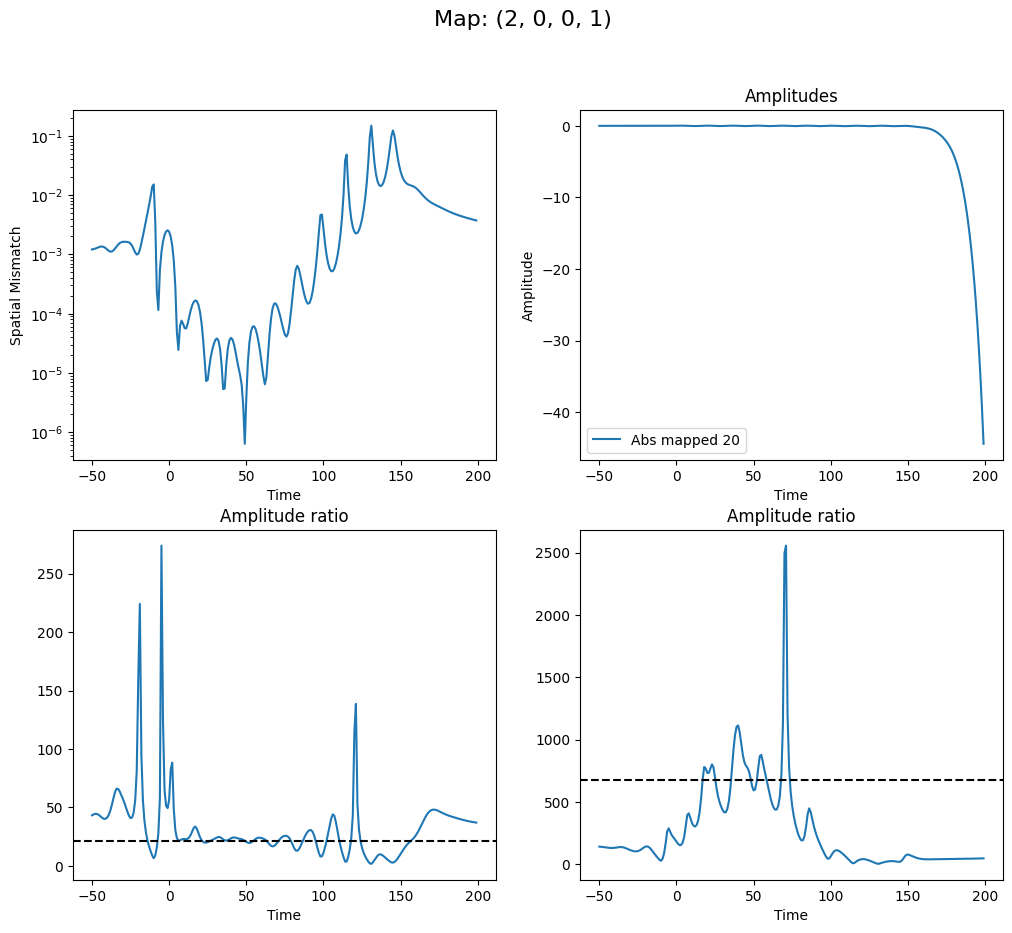

In [96]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

fig.suptitle(f"Map: {map}", fontsize=16)

axs[0,0].set_ylabel('Spatial Mismatch')
axs[0,0].set_xlabel('Time')
axs[0,0].plot(times, sm_list)

axs[0,0].set_yscale('log')

axs[0,1].set_title('Amplitudes')
axs[0,1].set_ylabel('Amplitude')
axs[0,1].set_xlabel('Time')
axs[0,1].plot(times, amplitudes1, label=f'Abs mapped 20')
axs[0,1].plot(times, amplitudes2, label=f'Abs mapped 30')
axs[0,1].plot(times, amplitudes3, label=f'Abs mapped 40')
axs[0,1].legend()

axs[1,0].set_title('Amplitude ratio')
axs[1,0].set_xlabel('Time')
axs[1,0].plot(times, ratio1, label=f'Abs mapped 20/30')

axs[1,1].set_title('Amplitude ratio')
axs[1,1].set_xlabel('Time')
axs[1,1].plot(times, ratio2, label=f'Abs mapped 20/40')

axs[1,0].axhline(y=abs(mu20/mu30), color='black', linestyle='--', label=f'Expected 20/40')
axs[1,1].axhline(y=abs(mu20/mu40), color='black', linestyle='--', label=f'Expected 20/40')


### Mapping quadratic modes

In [87]:
lon = np.linspace(-np.pi, np.pi, 200)
lat = np.linspace(-np.pi/2, np.pi/2, 200)
Lon, Lat = np.meshgrid(lon, lat)

t_start = -50
t_end = 200
t_step = 1
times = np.arange(t_start, t_end, t_step)

mapping = [(2,2,0,1,2,-2,0,-1)]
map = mapping[0]
l1,m1,n1,p1,l2,m2,n2,p2 = map
lp = l1 + l2
mp = m1 + m2

QNMs = [(lam,mu,n,p) for lam in np.arange(2, l_max+1)
                        for mu in np.arange(-lam, lam+1)
                           for n in np.arange(0, n_max+1)
                              for p in (-1, +1)]

spherical_modes = [(l,0) for l in np.arange(2, l_max+1)]

In [88]:
sm_list = []
amplitudes1 = [] 
amplitudes2 = []
amplitudes3 = []

sphindex1 = spherical_modes.index((2,0))
sphindex2 = spherical_modes.index((3,0))
sphindex3 = spherical_modes.index((4,0))

G = spheroidal(np.pi/2-Lat, Lon, map, l_max, sim.chif_mag)

for t0 in times:

   best_fit = qnmfits.mapping_multimode_ringdown_fit(sim.times, 
                                          sim.h, 
                                          modes=QNMs.copy(),
                                          Mf=sim.Mf,
                                          chif=sim.chif_mag,
                                          t0=t0,
                                          mapping_modes=mapping,
                                          spherical_modes=spherical_modes)

   F = mode_mapping(np.pi/2-Lat, Lon, best_fit, map, l_max)
   sm, arg, z = spatial_mismatch(F, G, num_points=100)
   sm_list.append(sm)

   amplitudes1.append(best_fit['C'][len(QNMs) + sphindex1])
   amplitudes2.append(best_fit['C'][len(QNMs) + sphindex2])
   amplitudes3.append(best_fit['C'][len(QNMs) + sphindex3])

In [89]:
mu20 = qnmfits.qnm.alpha([(2,0)+map], sim.chif_mag)[0]
mu30 = qnmfits.qnm.alpha([(3,0)+map], sim.chif_mag)[0]
mu40 = qnmfits.qnm.alpha([(4,0)+map], sim.chif_mag)[0]

ratio1 = [abs(a / b) for a, b in zip(amplitudes1, amplitudes2)]
ratio2 = [abs(a / b) for a, b in zip(amplitudes1, amplitudes3)]

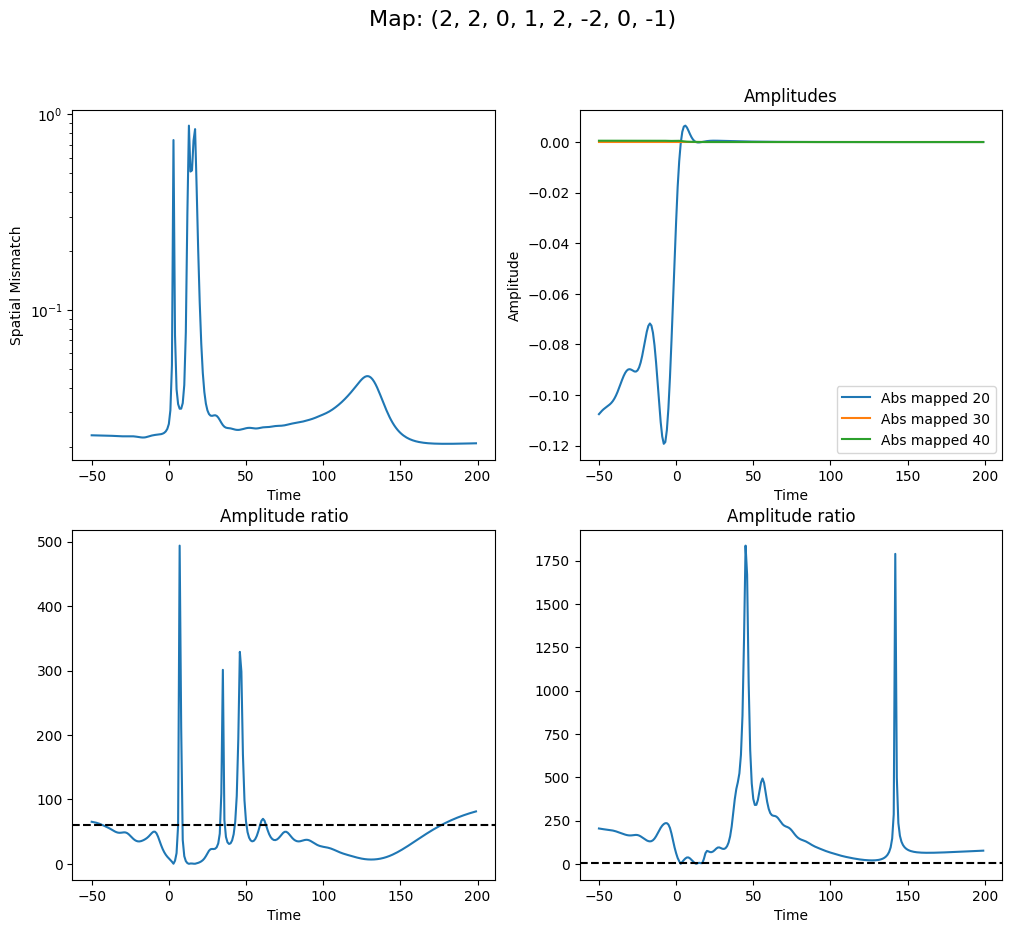

In [90]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

fig.suptitle(f"Map: {map}", fontsize=16)

axs[0,0].set_ylabel('Spatial Mismatch')
axs[0,0].set_xlabel('Time')
axs[0,0].plot(times, sm_list)

axs[0,0].set_yscale('log')

axs[0,1].set_title('Amplitudes')
axs[0,1].set_ylabel('Amplitude')
axs[0,1].set_xlabel('Time')
axs[0,1].plot(times, amplitudes1, label=f'Abs mapped 20')
axs[0,1].plot(times, amplitudes2, label=f'Abs mapped 30')
axs[0,1].plot(times, amplitudes3, label=f'Abs mapped 40')
axs[0,1].legend()

axs[1,0].set_title('20/30')
axs[1,0].set_xlabel('Time')
axs[1,0].plot(times, ratio1, label=f'Abs mapped 20/30')

axs[1,1].set_title('20/40')
axs[1,1].set_xlabel('Time')
axs[1,1].plot(times, ratio2, label=f'Abs mapped 20/40')

axs[1,0].axhline(y=abs(mu20/mu30), color='black', linestyle='--', label=f'Expected 20/40')
axs[1,1].axhline(y=abs(mu20/mu40), color='black', linestyle='--', label=f'Expected 20/40')